# Επίδοση Υπολογιστικών Συστημάτων
## Θέμα 2

Στυλιανός Κανδυλάκης, 03117088

Χαρίτων Χαριτωνίδης, 03116694

In [1]:
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)

Εισάγουμε τα δεδομένα της εκφώνησης

In [2]:
categories = ('A', 'B')

# cpu arrival rates (jobs / sec)
cpu_arrival_rate = {
    'A': 0.9,
    'B': 1.2
}

# average service times (sec)
cpu_average_service_time = {
    'A': 31e-3,
    'B': 42e-3
}

disk_average_service_time = {
    'A': 26e-3,
    'B': 29e-3
}

# average disk visits
average_disk_visits = {
    'A': 10,
    'B': 8
}

Το `disk_arrival_rate` είναι ο ρυθμός με τον οποίο μια εργασία μεταβαίνει από τη CPU στο δίσκο

In [3]:
# disk arrival rates (jobs / sec)
disk_arrival_rate = {cat: average_disk_visits[cat] / cpu_average_service_time[cat] for cat in categories}

Ορίζουμε την κλάση Job για να διευκολύνουμε την προσομοίωση

In [4]:
class Job:
    def __init__(self, category, time):
        self.category = category
        self.start_time = time
        self.end_time = None
        self.disk_visits = 0
        
        if category == 'A':
            self.remaining_time = np.random.exponential(scale=cpu_average_service_time['A'])
        elif category == 'B':
            self.remaining_time = np.random.exponential(scale=cpu_average_service_time['B'])
        self.disk_remaining_time = None
            
    def move_to_disk(self):
        self.disk_visits += 1
        self.disk_remaining_time = np.random.exponential(scale=disk_average_service_time[self.category])

Η παρακάτω συναρτηση εισάγει μια εργασία σε μία ουρά στην οποία εφαρμόζεται ο κανόνας preemptive priority που περιγράφεται στην εκφώνηση. Δηλαδή όταν έρχεται εργασία κατηγορίας Α προσπερνά τις εργασίες κατηγορίας Β, ακόμα κι αν μια εργασία κατηγορίας Β είναι υπό επεξεργασία.

In [5]:
def insert(job, queue):
    if not queue:
        queue = [job]
        return queue
    elif job.category == 'B':
        queue.append(job)
        return queue
    elif job.category == 'A':
        p = len(queue)
        while queue[p-1].category == 'B' and p > 0:
            p -= 1
        queue.insert(p, job)
        return queue

Η προσομοίωση γίνεται ως εξής: Χωρίζουμε το χρόνο σε πολύ μικρά διαστήματα ώστε να έχουμε 

$$
    P[\text{άφιξης στο διάστημα } dt]  = \text{ρυθμός αφίξεων} \cdot dt
$$

Και έπειτα προχωράμε το χρόνο κατά dt σε κάθε επανάληψη της προσομοίωσης. Όταν έρχεται μια νέα εργασία, την προσθέτουμε στην ουρά της CPU με υπολειπόμενο χρόνο (πεδίο `remaining_time` στο `Job`) δείγμα από εκθετική κατανομή με μέσο όρο τον μέσο χρόνο ανά επίσκεψη στη cpu ανάλογα με την κατηγορία της εργασίας.

Επίσης υπολογίζουμε την πιθανότητα στο διάστημα dt η εργασία να μεταβεί από τη CPU στο δίσκο 

$$
    P[\text{μετάβασης από τη CPU στο δίσκο στο διάστημα dt}] = \frac{\text{Μέσος αριθμός επισκέψεων στο δίσκο}}{\text{Μέσος χρόνος εξυπηρέτησης στη CPU}} \cdot \text{dt}
$$

Αυτό ισχύει για αρκούντως μικρό $dt$

Τα σημεία αναγεννησης είναι οι στιγμές που μια νέα εργασία "βρίσκει" το σύστημα (CPU και disk) άδειο.

In [6]:
t = 0
np.random.seed(42)
random.seed(42)
CPU_queue = []
disk_queue = []
completed_jobs = []
cpu_history = []
disk_history = []
regeneration_points = []
max_regeneration_cycles = 1000
confidence_level = 0.95
dt = 1e-3

while len(regeneration_points) < max_regeneration_cycles:
    if CPU_queue:
        # if there are jobs in the cpu queue, process the one with the highest priority
        CPU_queue[0].remaining_time -= dt
        if CPU_queue[0].remaining_time <= 0:
            # if it's done, keep it in the completed list and remove it from the queue
            CPU_queue[0].end_time = t
            completed_jobs.append(CPU_queue[0])
            CPU_queue.pop(0)
        elif random.random() < disk_arrival_rate[CPU_queue[0].category] * dt:
            # jobs move to disk
            CPU_queue[0].move_to_disk()
            disk_queue.append(CPU_queue[0])
            CPU_queue.pop(0)

    # disk
    if disk_queue:
        # if the disk is not empty, process the job with the highest priority
        disk_queue[0].disk_remaining_time -= dt
        if disk_queue[0].disk_remaining_time <= 0:
            # if the job with the highest priority is done move it back to the cpu
            CPU_queue = insert(disk_queue[0], CPU_queue)
            disk_queue.pop(0)
    
    # new arrivals
    if random.random() < cpu_arrival_rate['A'] * dt:
        if CPU_queue == [] and disk_queue == []:
            regeneration_points.append(t)
        CPU_queue = insert(Job(category='A', time=t), CPU_queue)
    if random.random() < cpu_arrival_rate['B'] * dt:
        if CPU_queue == [] and disk_queue == []:
            regeneration_points.append(t)
        CPU_queue = insert(Job(category='B', time=t), CPU_queue)
    
    if len(regeneration_points) % 20 == 0 and len(regeneration_points) > 0:
        response_times_B = [job.end_time - job.start_time for job in completed_jobs if job.category == 'B']
        # ci = confidence interval length
        ci = 2 * confidence_level * np.std(response_times_B) / np.sqrt(len(response_times_B))
        if ci < 0.1 * np.mean(response_times_B):
            break
    
    cpu_history.append(len(CPU_queue))
    disk_history.append(len(disk_queue))
    t += dt

## Αποτελέσματα προσομοίωσης

In [7]:
response_times = [job.end_time - job.start_time for job in completed_jobs]
print('Average response time:', sum(response_times) / len(response_times))
response_times_A = [job.end_time - job.start_time for job in completed_jobs if job.category=='A']
print('Average response time for category A:', sum(response_times_A) / len(response_times_A))
response_times_B = [job.end_time - job.start_time for job in completed_jobs if job.category=='B']
print('Average response time for category B:', sum(response_times_B) / len(response_times_B))
print('=============================================')
print('Number of completed jobs:', len(completed_jobs))
print('Number of category A completed jobs', len(list(filter(lambda job: job.category == 'A', completed_jobs))))
print('Number of category A completed jobs', len(list(filter(lambda job: job.category == 'B', completed_jobs))))
print('=============================================')
print('CPU Utilization =', len(list(filter(lambda x: x != 0, cpu_history))) / len(cpu_history))
print('Disk Utilization =', len(list(filter(lambda x: x != 0, disk_history))) / len(disk_history))
print('=============================================')
print('Total regeneration cycles:', len(regeneration_points))

Average response time: 0.5490286069576695
Average response time for category A: 0.5930384047184346
Average response time for category B: 0.51702577872562
Number of completed jobs: 1608
Number of category A completed jobs 677
Number of category A completed jobs 931
CPU Utilization = 0.08049634803555711
Disk Utilization = 0.506423751409056
Total regeneration cycles: 780


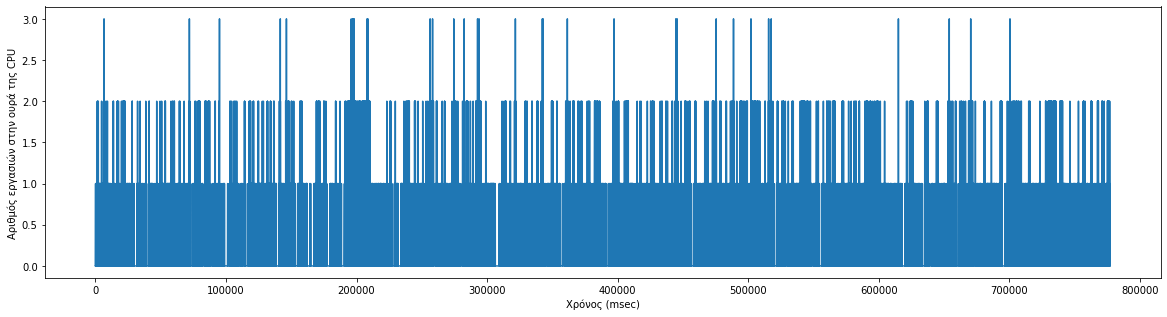

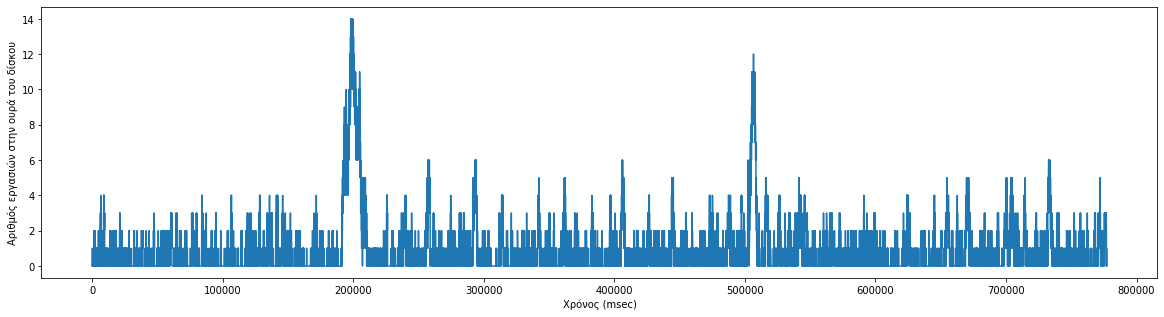

In [8]:
plt.plot(cpu_history)
plt.xlabel('Χρόνος (msec)')
plt.ylabel('Αριθμός εργασιών στην ουρά της CPU')
plt.show()

plt.plot(disk_history)
plt.xlabel('Χρόνος (msec)')
plt.ylabel('Αριθμός εργασιών στην ουρά του δίσκου')
plt.show()

# Σχολιασμός αποτελεσμάτων

## Utilization


Όπως αναμένουμε έχουμε πολύ μεγαλύτερο utilization στο δίσκο σε σχέση με τη CPU. Αυτό είναι αναμενόμενο, αφού η επεξεργασία μιας εργασίας στη CPU διαρκεί 31 msec (42 msec) για την κατηγορία Α (αντίστοιχα για την κατηγορία Β), ενώ στο δίσκο κάθε εργασία κάνει 10 (8) επισκέψεις των 26 msec (29 msec αντίστοιχα). Θεωρητικά έχουμε 

$$
    U_{CPU} = U_{CPU_A} + U_{CPU_B} = \lambda_A \cdot S_A + \lambda_B \cdot S_B = 
    0.9 \cdot 1 \cdot 0.031 + 1.2  \cdot 0.042 = 0.0783
$$

$$
    U_{disk} = U_{disk_A} + U_{disk_B} = 
    \lambda_A \cdot V_A \cdot S_{A_{disk}} + \lambda_B \cdot V_B \cdot S_{B_{disk}} = 
    0.9 \cdot 10 \cdot 0.026 + 1.2 \cdot 8 \cdot 0.031 =
    0.5316
$$


Παρατηρούμε ότι τα αποτελέσματα της προσομοίωσης είναι πολύ κοντά στις θεωρητικές τιμές.

## Μέσοι χρόνοι απόκρισης

Ο μέσος χρόνος απόκρισης είναι $\approx 0.59$ sec για την κατηγορία Α και $\approx 0.52$ για την κατηγορία Β. Μια εργασία τύπου A σε άδειο σύστημα χρειάζεται κατά μέσο όρο 291 msec ($0.31 + 10 \cdot 26$), ενώ μια εργασία κατηγορίας Β χρειάζεται κατά μέσο όρο 274 msec ($42 + 8 \cdot 29$). Εδώ φαίνεται πως οι εργασίες της κατηγορίας Α έχουν πάρει περισσότερο χρόνο σε σχέση με τις εργασίες κατηγορίας B. Πιστεύουμε πως αυτό οφείλεται στο ότι δεν υπάρχει κανόνας προτεραιότητας στην ουρά του δίσκου, και καθώς οι περισσότερες εργασίες είναι της κατηγορίας Β και ο δίσκος είναι κατειλημένος το 50% του χρόνου, οι εργασίες της κατηγορίας Α "κολλάνε" στην ουρά του δίσκο πίσω από εργασίες κατηγορίας Β.

Για να δοκιμάσουμε αν αυτό είναι όντως ο λόγος, μπορούμε να ξανατρέξουμε την προσομοίωση, αυτή τη φορά με κανόνα προτεραιότητας και στην ουρά του δίσκου (θα χρησιμοποιήσουμε τη συνάρτηση `insert()` που ορίσαμε παραπάνω αντί για `append()` στην ουρά του δίσκου.


In [9]:
t = 0
np.random.seed(42)
random.seed(42)
CPU_queue = []
disk_queue = []
completed_jobs = []
cpu_history = []
disk_history = []
regeneration_points = []
max_regeneration_cycles = 1000
confidence_level = 0.95
dt = 1e-3

while len(regeneration_points) < max_regeneration_cycles:
    if CPU_queue:
        # if there are jobs in the cpu queue, process the one with the highest priority
        CPU_queue[0].remaining_time -= dt
        if CPU_queue[0].remaining_time <= 0:
            # if it's done, keep it in the completed list and remove it from the queue
            CPU_queue[0].end_time = t
            completed_jobs.append(CPU_queue[0])
            CPU_queue.pop(0)
        elif random.random() < disk_arrival_rate[CPU_queue[0].category] * dt:
            # jobs move to disk
            CPU_queue[0].move_to_disk()
            disk_queue = insert(CPU_queue[0], disk_queue)
            CPU_queue.pop(0)

    # disk
    if disk_queue:
        # if the disk is not empty, process the job with the highest priority
        disk_queue[0].disk_remaining_time -= dt
        if disk_queue[0].disk_remaining_time <= 0:
            # if the job with the highest priority is done move it back to the cpu
            CPU_queue = insert(disk_queue[0], CPU_queue)
            disk_queue.pop(0)
    
    # new arrivals
    if random.random() < cpu_arrival_rate['A'] * dt:
        if CPU_queue == [] and disk_queue == []:
            regeneration_points.append(t)
        CPU_queue = insert(Job(category='A', time=t), CPU_queue)
    if random.random() < cpu_arrival_rate['B'] * dt:
        if CPU_queue == [] and disk_queue == []:
            regeneration_points.append(t)
        CPU_queue = insert(Job(category='B', time=t), CPU_queue)
    
    if len(regeneration_points) % 20 == 0 and len(regeneration_points) > 0:
        response_times_B = [job.end_time - job.start_time for job in completed_jobs if job.category == 'B']
        # ci = confidence interval length
        ci = 2 * confidence_level * np.std(response_times_B) / np.sqrt(len(response_times_B))
        if ci < 0.1 * np.mean(response_times_B):
            break
    
    cpu_history.append(len(CPU_queue))
    disk_history.append(len(disk_queue))
    t += dt

## Αποτελέσματα προσομοίωσης με preemptive priority της κατηγορίας Α και στο δίσκο

In [10]:
response_times = [job.end_time - job.start_time for job in completed_jobs]
print('Average response time:', sum(response_times) / len(response_times))
response_times_A = [job.end_time - job.start_time for job in completed_jobs if job.category=='A']
print('Average response time for category A:', sum(response_times_A) / len(response_times_A))
response_times_B = [job.end_time - job.start_time for job in completed_jobs if job.category=='B']
print('Average response time for category B:', sum(response_times_B) / len(response_times_B))
print('=============================================')
print('Number of completed jobs:', len(completed_jobs))
print('Number of category A completed jobs', len(list(filter(lambda job: job.category == 'A', completed_jobs))))
print('Number of category A completed jobs', len(list(filter(lambda job: job.category == 'B', completed_jobs))))
print('=============================================')
print('CPU Utilization =', len(list(filter(lambda x: x != 0, cpu_history))) / len(cpu_history))
print('Disk Utilization =', len(list(filter(lambda x: x != 0, disk_history))) / len(disk_history))
print('=============================================')
print('Total regeneration cycles:', len(regeneration_points))

Average response time: 0.498332082545462
Average response time for category A: 0.3340336322832436
Average response time for category B: 0.6165209677340903
Number of completed jobs: 1066
Number of category A completed jobs 446
Number of category A completed jobs 620
CPU Utilization = 0.07923436063099813
Disk Utilization = 0.4863256227058722
Total regeneration cycles: 500


Βλέπουμε ξεκάθαρα ότι οι χρόνοι απόκρισης μειώθηκαν δραματικά όταν η κατηγορία Α έχει απόλυτη προτεραιότητα και στην ουρά του δίσκου. Επίσης χρειάστηκαν λιγότεροι αναγεννητικοί κύκλοι για να έχουμε σύκγλιση. Άρα όντως, αυτό που καθυστερούσε τις εργασίες της κατηγορίας Α ήταν η απουσία προτεραιότητας στην ουρά του δίσκου.